# Users Overview Analysis

For the actual telecom dataset, you‘re expected to conduct a full User Overview analysis & the following sub-tasks are your guidance: 
Start by 
- identifying the top 10 handsets used by the customers.
- Then, identify the top 3 handset manufacturers
- Next, identify the top 5 handsets per top 3 handset manufacturer
- Make a short interpretation and recommendation to marketing teams


# imports

In [1]:
# general
import os
import gc
import sys

# wranglers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# custom modules
cwd = os.getcwd()
parent = cwd.replace('/notebooks', '')
sys.path.insert(0, parent) 

from utils import DataLoader

# load data

In [2]:
df = DataLoader("../data", "Week1_challenge_data_source.csv").read_csv()

In [3]:
def plot_top_n_counts(df: pd.DataFrame, column: str, top_n: int, title: str, color: str="green") -> pd.Series:
    top_n_count = df[column].value_counts().nlargest(top_n)
    axis = top_n_count.plot.bar(color=color, title=title, fontsize=20, figsize=(9, 6))
    
    return top_n_count

# Top 10 handsets used by customers

Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: Handset Type, dtype: int64

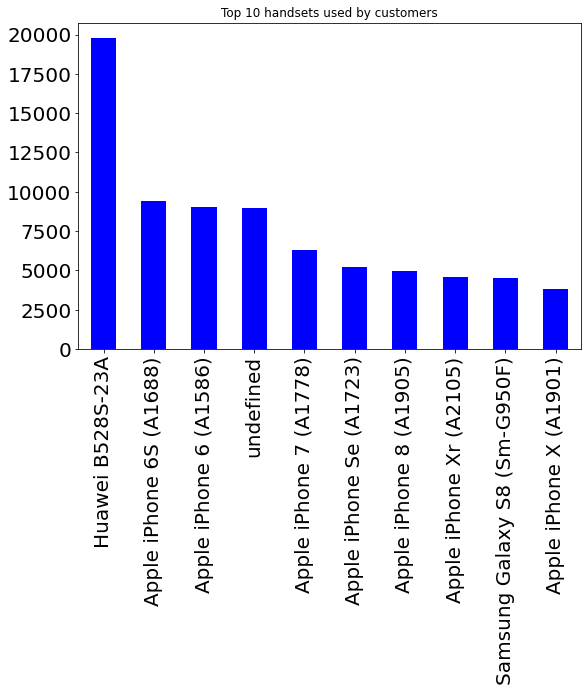

In [4]:
top_10_handsets = plot_top_n_counts(df, 'Handset Type', 10, title="Top 10 handsets used by customers", color="blue")
top_10_handsets

# Top 3 handset manufacturers

Apple      59565
Samsung    40839
Huawei     34423
Name: Handset Manufacturer, dtype: int64

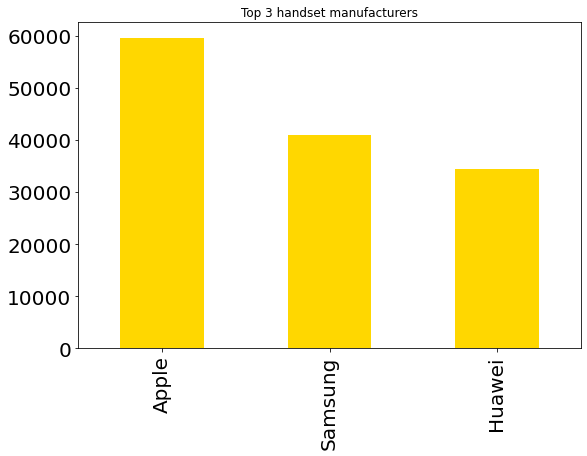

In [5]:
top_3_handset_manu = plot_top_n_counts(df, 'Handset Manufacturer', 3, color='gold', title='Top 3 handset manufacturers')
top_3_handset_manu

# Top 5 handsets per top 3 handset manufacturer

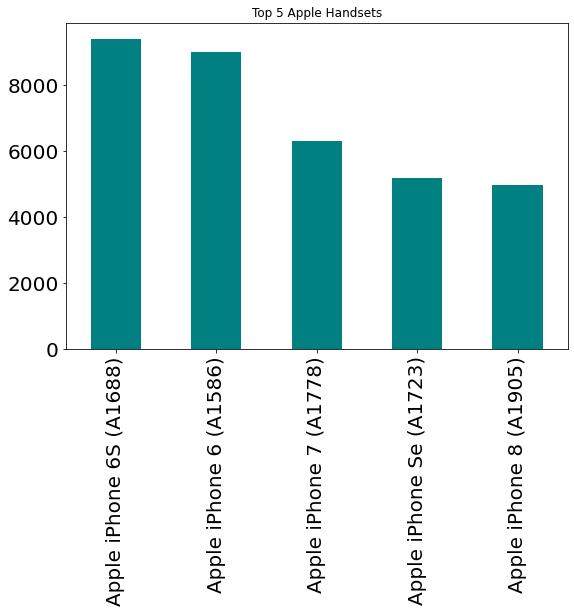

In [6]:
apple = df[df['Handset Manufacturer']=='Apple']
top_5_apple = plot_top_n_counts(apple, 'Handset Type', 5, "Top 5 Apple Handsets", color="teal")

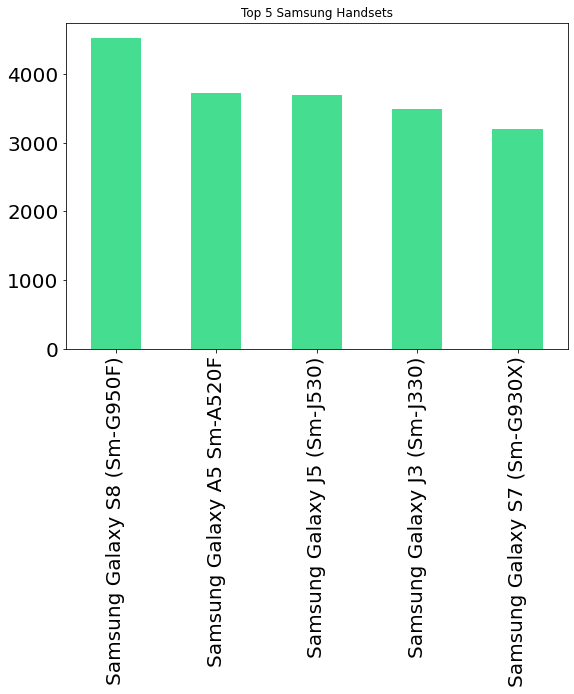

In [7]:
samsung = df[df['Handset Manufacturer']=='Samsung']
top_5_samsung = plot_top_n_counts(samsung, 'Handset Type', 5, "Top 5 Samsung Handsets", color="#45De90")

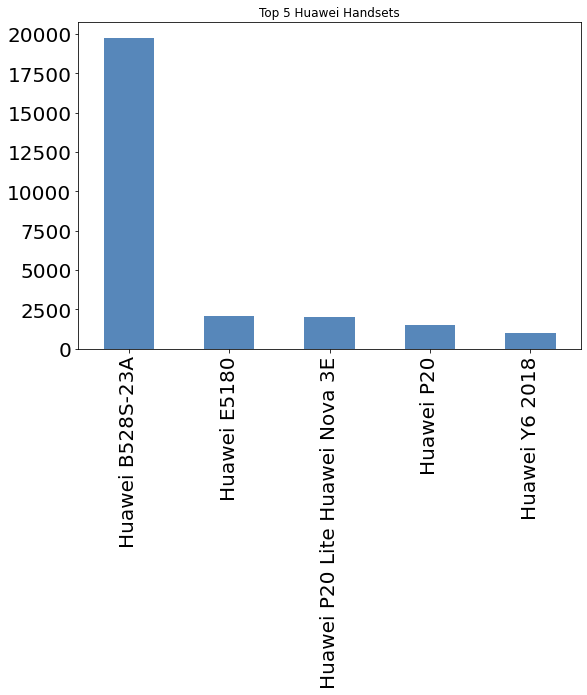

In [8]:
huawei = df[df['Handset Manufacturer']=='Huawei']
top_5_huawei = plot_top_n_counts(huawei, 'Handset Type', 5, "Top 5 Huawei Handsets", color="#5787BA")

# Users’ behavior on applications
**(Social Media, Google, Email, Youtube, Netflix, Gaming, Other)**

Aggregate per user the following information in the column  

    - number of xDR sessions
    - Session duration
    - the total download (DL) and upload (UL) data
    - the total data volume (in Bytes) during this session for each application



## Note on a couple of columns (**IMSI** and **MSISDN**)

Since this tasks involved I needed to see if I had columns that would help me identify specifc users. 
And a quick scan of the `Field Descriptions.xlsx` file gave me the idea that the **IMSI** (***International Mobile Subscriber Identity***) and **MSISDN** (***Mobile Station Integrated Services Digital Network***) might be good candidates.
I also considered using the **IMEI** (***International Mobile Equipment Identity***) but then there might be cases where the same person uses multiple handsets.

The **IMSI** is an identifier that is stored on the **SIM** (***subscriber identity module***) card of a subscriber. It is a static 15 digit number used by Network operators to identify subsribers on a network. 
The **MSISDN** is the phone number assigned to a subscriber inorder for it to communicate with other subscribers. They are also not bound to a single device or SIM. 
A subscriber could even have multiple **MSISDN** associated with a single **IMSI**

Both identifiers might work for the task with a few twists, but I will stick to the **IMSI** since it's static and is also used by network operators to identify subscribers.

[**Reference**](https://www.wirelesslogic.com/what-is-msisdn/)

In [9]:
unique_IMSI = df['IMSI'].unique()
print(f"We have {unique_IMSI.shape[0]} unique IMSI identifiers in our dataset")

We have 107266 unique IMSI identifiers in our dataset


## Task 1.1 - Aggrigations per user

### Number of xDR sessions

In [10]:
user_xdr_count = df.groupby(by='IMSI')['Bearer Id'].count()
print("Let's look at our per user xDR counts")
display(user_xdr_count.head())
print("The unique counts are the following")
display(user_xdr_count.unique())
print("And the Mean is as follows")
display(user_xdr_count.mean())

Let's look at our per user xDR counts


IMSI
2.040471e+14    1
2.040808e+14    1
2.082001e+14    1
2.082001e+14    1
2.082001e+14    2
Name: Bearer Id, dtype: int64

The unique counts are the following


array([ 1,  2,  0,  4,  3,  6,  5,  8,  7, 12, 10, 13,  9, 17, 15, 11, 18,
       16])

And the Mean is as follows


1.3890924346245281

### Session Duration

In [11]:
user_session_durations = df.groupby(by='IMSI')['Dur. (ms)'].sum()
assert user_session_durations.shape[0], unique_IMSI.shape[0]
print("Let's look at our per user session durations in (ms)")
display(user_session_durations.head())


Let's look at our per user session durations in (ms)


IMSI
2.040471e+14    869844.0
2.040808e+14    877385.0
2.082001e+14     86019.0
2.082001e+14     86254.0
2.082001e+14    573923.0
Name: Dur. (ms), dtype: float64

### The total download (DL) and upload (UL) data

In [12]:
user_total_DLUL = df.groupby(by='IMSI')[['Total UL (Bytes)', 'Total DL (Bytes)']].sum()
print("This will be the sum of each users UL and DL usages in (Bytes)")
display(user_total_DLUL.head())
print("But we need the total as a single number for each user, so we sum it across the columns")
user_total_DLUL = user_total_DLUL.sum(axis=1)
display(user_total_DLUL.head())

This will be the sum of each users UL and DL usages in (Bytes)


,Total UL (Bytes),Total DL (Bytes)
IMSI,,
2.040471e+14,60456049.0,78697597.0
2.040808e+14,37295915.0,194828056.0
2.082001e+14,53794658.0,31376981.0
2.082001e+14,33583272.0,392918313.0
2.082001e+14,71325004.0,961767023.0


But we need the total as a single number for each user, so we sum it across the columns


IMSI
2.040471e+14    1.391536e+08
2.040808e+14    2.321240e+08
2.082001e+14    8.517164e+07
2.082001e+14    4.265016e+08
2.082001e+14    1.033092e+09
dtype: float64

### The total data volume (in Bytes) during these session for each application

In [13]:
app_columns = [col for col in df.columns if col.endswith('L (Bytes)')][2:-2]
display(app_columns)
user_app_ULDL_data_vol = df.groupby(by=['IMSI'])[app_columns].sum()
user_app_ULDL_data_vol.head()

['Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL (Bytes)',
 'Email DL (Bytes)',
 'Email UL (Bytes)',
 'Youtube DL (Bytes)',
 'Youtube UL (Bytes)',
 'Netflix DL (Bytes)',
 'Netflix UL (Bytes)',
 'Gaming DL (Bytes)',
 'Gaming UL (Bytes)',
 'Other DL (Bytes)',
 'Other UL (Bytes)']

,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
IMSI,,,,,,,,,,,,,,
2.040471e+14,1500145.0,45943.0,5985089.0,3233558.0,2518425.0,812549.0,18980320.0,21960390.0,21621336.0,7224894.0,28092282.0,14977978.0,3.891597e+08,12200737.0
2.040808e+14,668596.0,46628.0,8572779.0,1865881.0,842279.0,678492.0,9839889.0,2120016.0,10340908.0,16251392.0,164563605.0,13485133.0,4.676781e+08,2848373.0
2.082001e+14,3073697.0,49084.0,603691.0,1020971.0,3076735.0,580766.0,5556563.0,14325876.0,15305361.0,16525201.0,3760934.0,5363582.0,5.000445e+08,15929178.0
2.082001e+14,2542767.0,34337.0,10699827.0,3111651.0,3248863.0,606871.0,22414714.0,3242918.0,10065639.0,17720213.0,343946503.0,159394.0,3.009029e+08,8707888.0
2.082001e+14,3326811.0,99905.0,9118088.0,2547799.0,4225757.0,1338705.0,4046597.0,9793604.0,30748449.0,26594966.0,910301321.0,7383445.0,1.055869e+09,23566580.0


Now, I will create a new dataframe to combine the UL and DL volume for each app and assign back to the respective users

In [14]:
user_app_total_data_vol = user_app_ULDL_data_vol.copy()
# group columns into tuples
# app_ULDLs = [
app_ULDL_columns = user_app_total_data_vol.columns.tolist()
app_columns = [[app_ULDL_columns[i], app_ULDL_columns[i+1]] for i in range(0, len(app_ULDL_columns), 2)]
app_columns

[['Social Media DL (Bytes)', 'Social Media UL (Bytes)'],
 ['Google DL (Bytes)', 'Google UL (Bytes)'],
 ['Email DL (Bytes)', 'Email UL (Bytes)'],
 ['Youtube DL (Bytes)', 'Youtube UL (Bytes)'],
 ['Netflix DL (Bytes)', 'Netflix UL (Bytes)'],
 ['Gaming DL (Bytes)', 'Gaming UL (Bytes)'],
 ['Other DL (Bytes)', 'Other UL (Bytes)']]

In [15]:
for app in app_columns:
    app_name = " ".join(app[0].split()[:-2]).strip()
    user_app_total_data_vol[app_name] = user_app_total_data_vol[app].sum(axis=1)
    user_app_total_data_vol.drop(columns=app, inplace=True)
user_app_total_data_vol.head()

,Social Media,Google,Email,Youtube,Netflix,Gaming,Other
IMSI,,,,,,,
2.040471e+14,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08
2.040808e+14,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08
2.082001e+14,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08
2.082001e+14,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08
2.082001e+14,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09


## Univariat, Bivariat, Multivariate analysis
Conduct an exploratory data analysis on those data & communicate useful insights. 
Ensure that you identify and treat all missing values and outliers in the dataset by replacing by the mean of the corresponding column.

### Plotting and cleaning helpers

In [16]:
def fix_datatypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes in the tellco dataframe an casts columns to proper data types.
    Start and End -> from string to datetime.
    Bearer Id, IMSI, MSISDN, IMEI -> From number to string
    """
    df['Start']  = pd.to_datetime(df['Start'])
    df['End']  = pd.to_datetime(df['End'])
    df['IMSI']  = df['IMSI'].astype(str)
    df['MSISDN/Number']  = df['MSISDN/Number'].astype(str)
    df['IMEI']  = df['IMEI'].astype(str)
    df['Bearer Id']  = df['Bearer Id'].astype(str)
    
    return df


def percent_missing(df):
    """
    Print out the percentage of missing entries in a dataframe
    """
    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")


def handle_missing_value(tellco_df: pd.DataFrame, verbose=True) -> pd.DataFrame:
    if verbose:
        percent_missing(df)
        print(tellco_df.isnull().sum())
    numericals = tellco_df.select_dtypes(include='number').columns.tolist()
    # objects = tellco_df.select_dtypes(exclude=['number']).columns.tolist()
    if numericals:
        numeric_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            # ('scale', MinMaxScaler()),
            # ('normalize', Normalizer()),
        ])
        cleaned_numerical = pd.DataFrame(numeric_pipeline.fit_transform(tellco_df[numericals]))
        cleaned_numerical.columns = numericals
    
    # if objects:
#     object_pipeline = Pipeline(steps=[
#         ('impute', SimpleImputer(strategy='most_frequent'))
#     ])
#     cleaned_object = pd.DataFrame(object_pipeline.fit_transform(tellco_df[objects]))
#     cleaned_object.columns = objects
        
        
#     # if cleaned_object and cleaned_numerical:
#     cleaned_df = pd.concat([cleaned_object, cleaned_numerical], axis=1)
    if verbose:
        print(cleaned_numerical.info())
        # print("="*10, "missing values imputed, collumns scalled, and normalized", "="*10)
    return cleaned_numerical
    

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(5, 3))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    # sns.histplot(data=df, x=column, color=color, kde=True, height=7, aspect=2, bins=10)
    sns.histplot(data=df, x=column, color=color, bins=15, stat='count')
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()
    

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

    
def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

    
def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()


def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()

In [17]:
clean_df = fix_datatypes(df)
clean_df = handle_missing_value(clean_df, verbose=False)

### Non-Graphical Univariate Analysis

Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters for each quantitative variable and provide useful interpretation. 


In [18]:
# for col in clean_df.columns:
    # print(f"{col} Mean: {round(clean_df[col].describe())} KBs")

In [19]:
clean_df.describe()

,Start ms,End ms,Dur. (ms),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,150001.000000,150001.000000,1.500010e+05,150001.000000,150001.000000,150001.00000,150001.000000,1.500010e+05,1.500010e+05,150001.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05
mean,499.188199,498.800888,1.046084e+05,97.774455,15.315031,13299.95768,1770.417264,8.915464e+06,2.836918e+05,92.880721,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,288.610872,288.096693,8.103736e+04,559.909444,76.687998,23971.82300,4625.342183,1.176582e+08,1.578013e+07,13.015062,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127635e+07,2.441421e+08
min,0.000000,0.000000,7.142000e+03,0.000000,0.000000,0.00000,0.000000,2.000000e+00,1.000000e+00,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,250.000000,251.000000,5.744200e+04,35.000000,3.000000,43.00000,47.000000,5.687300e+05,2.094950e+04,91.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322203e+07,2.431072e+08
50%,499.000000,500.000000,8.639900e+04,45.000000,5.000000,63.00000,63.000000,5.687300e+05,2.094950e+04,100.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,749.000000,750.000000,1.324300e+05,62.000000,11.000000,19710.00000,1120.000000,5.687300e+05,2.094950e+04,100.000000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657051e+08
max,999.000000,999.000000,1.859336e+06,96923.000000,7120.000000,378160.00000,58613.000000,4.294426e+09,2.908226e+09,100.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


### Graphical Univariate Analysis
Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options for each variable and interpret your findings.

#### Visualize outliers with box plots

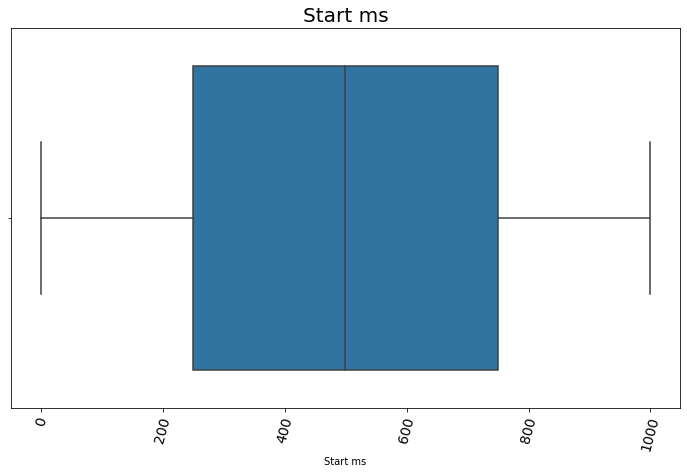

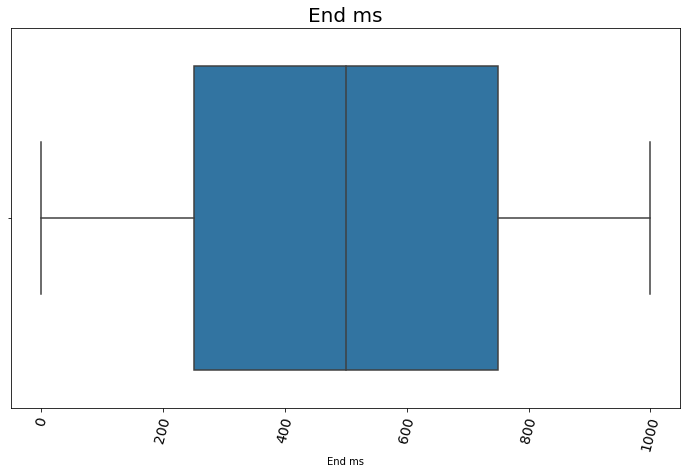

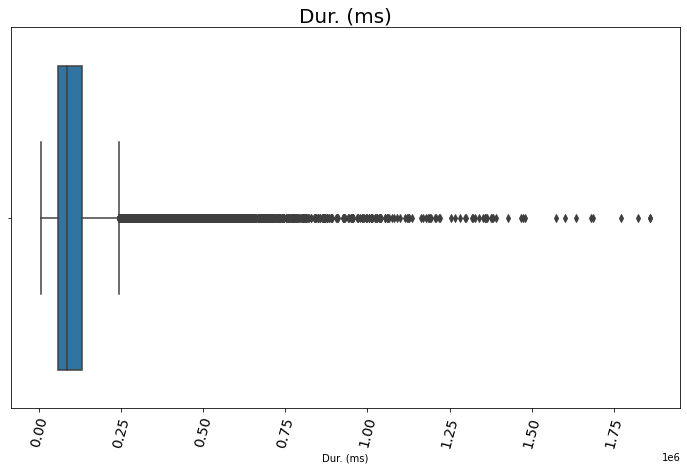

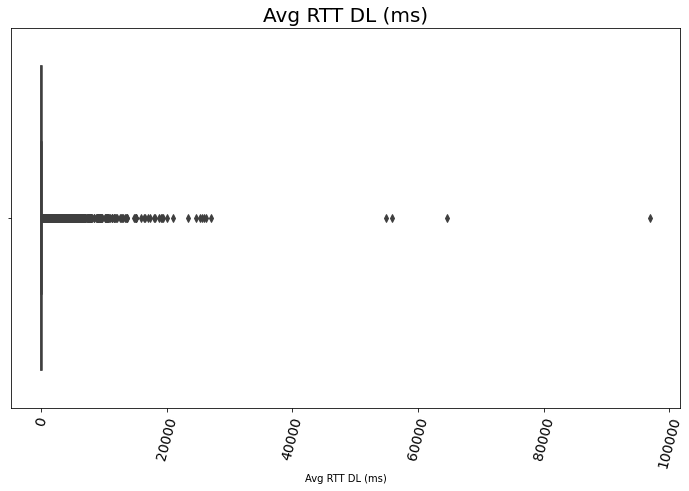

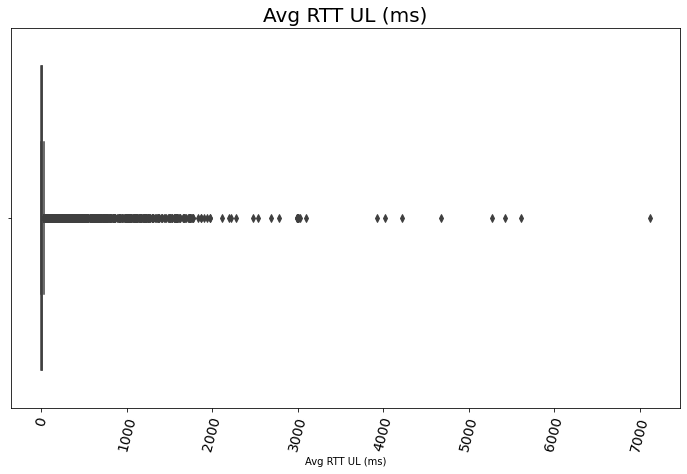

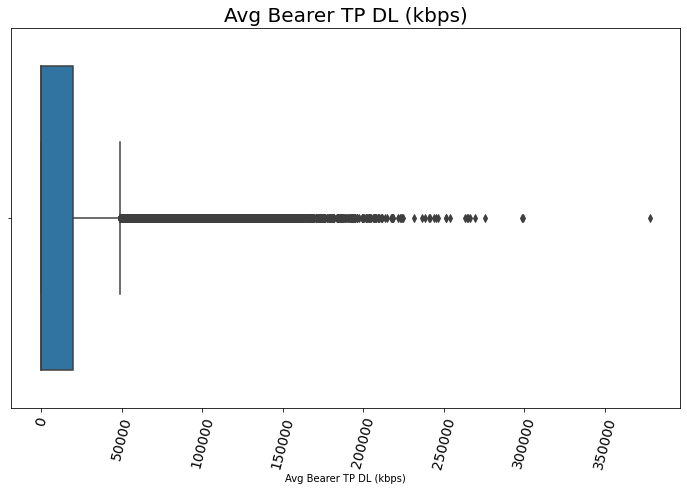

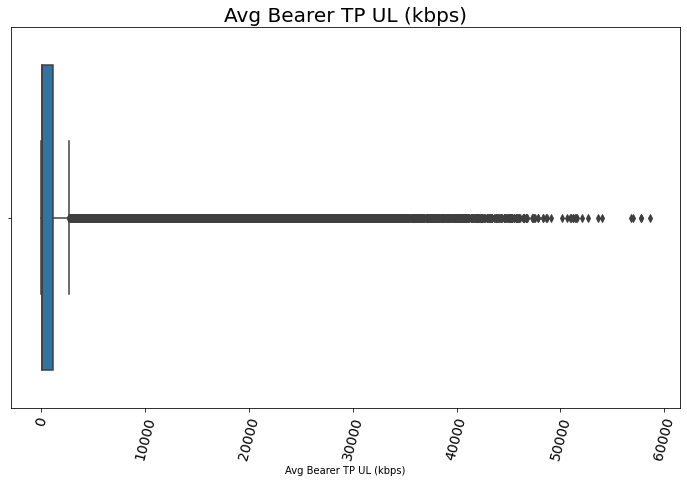

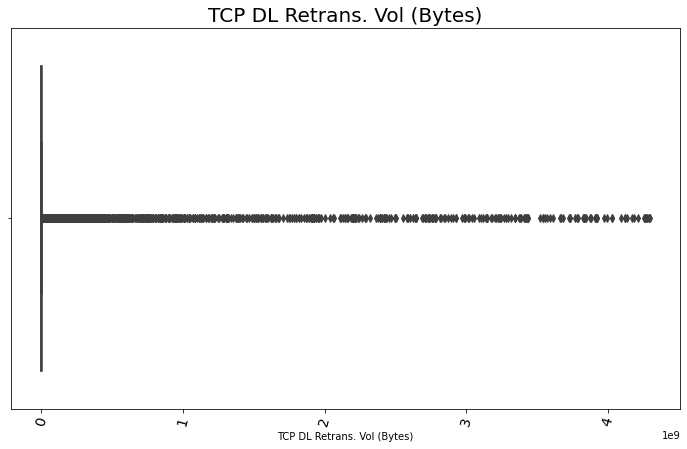

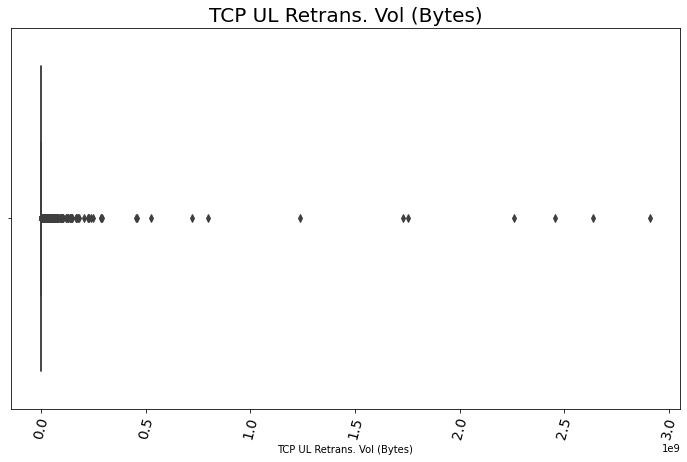

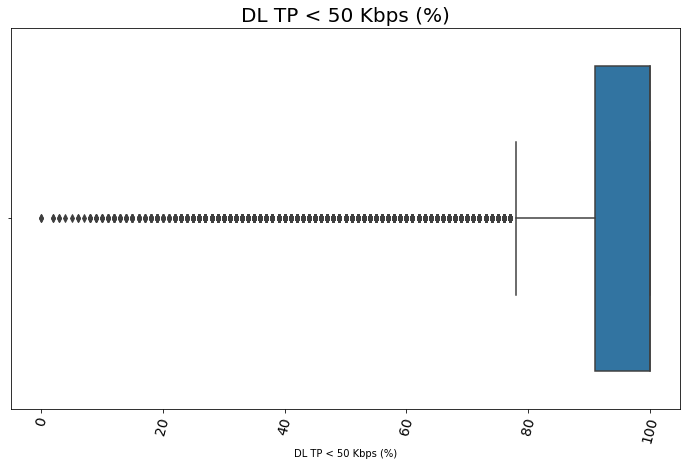

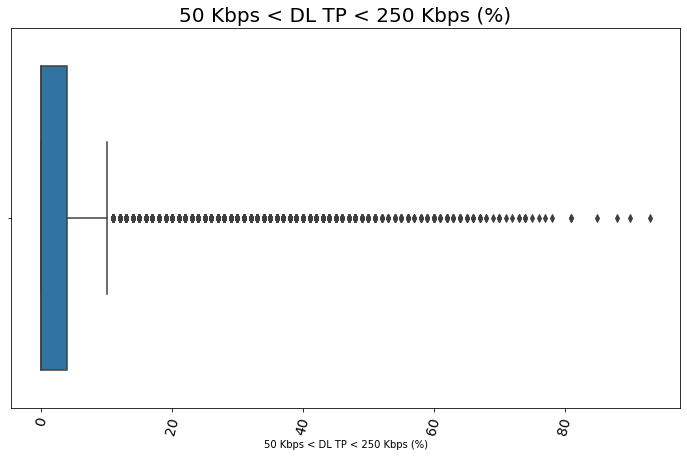

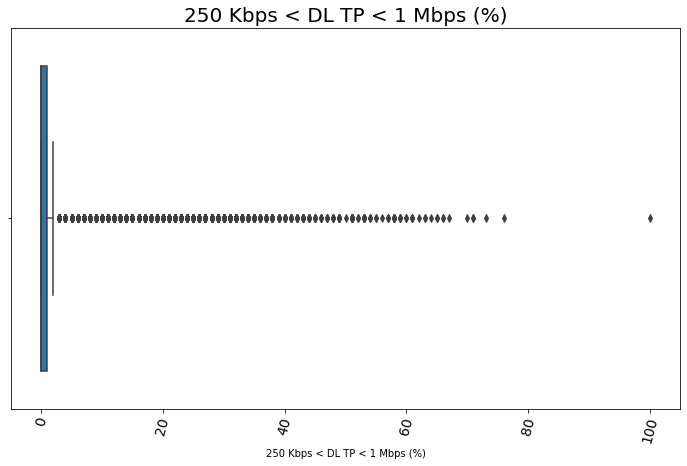

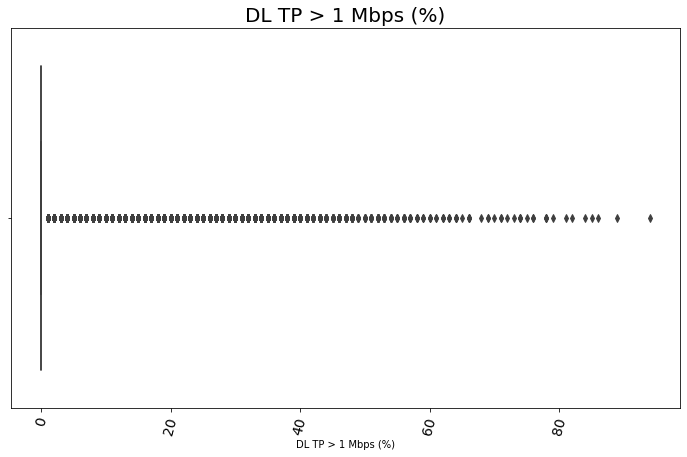

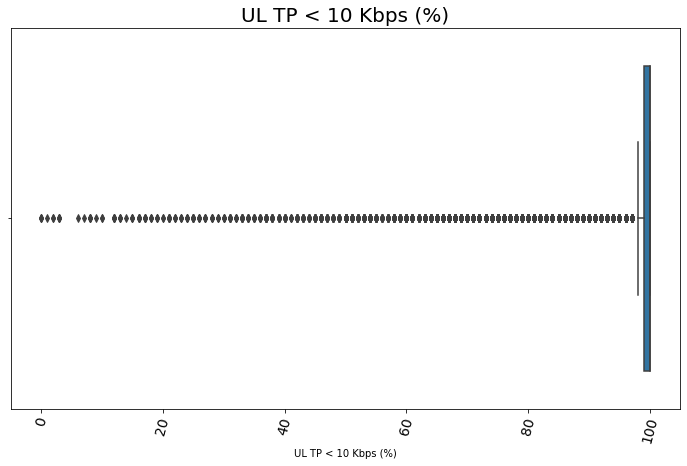

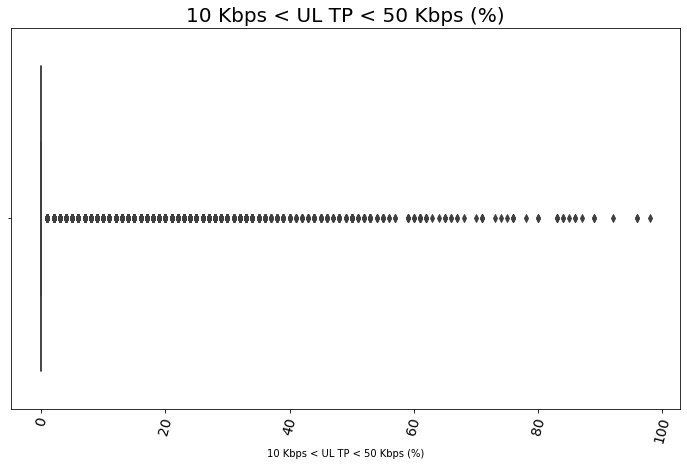

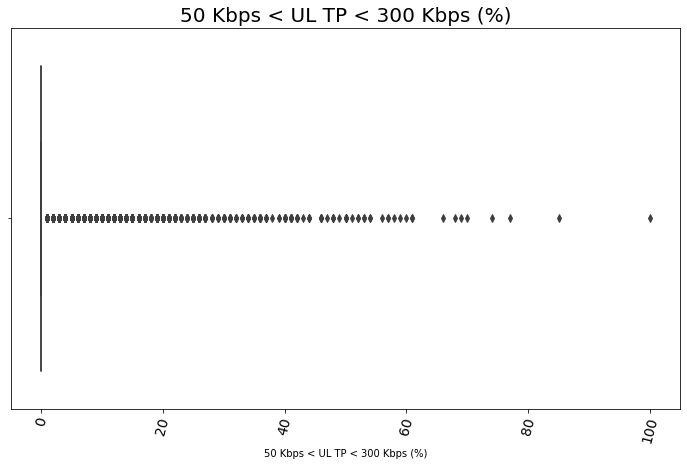

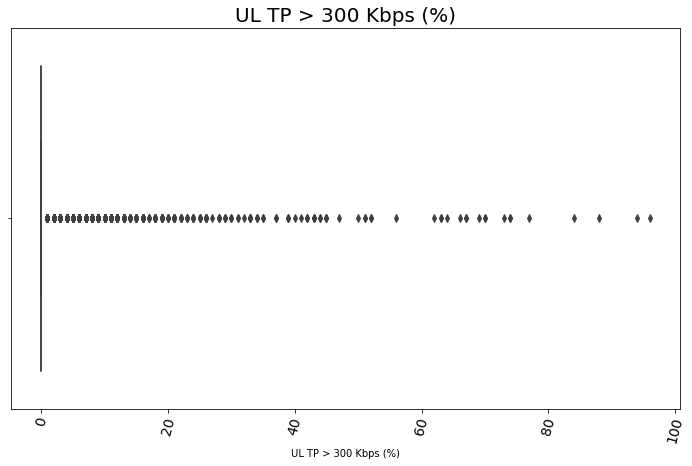

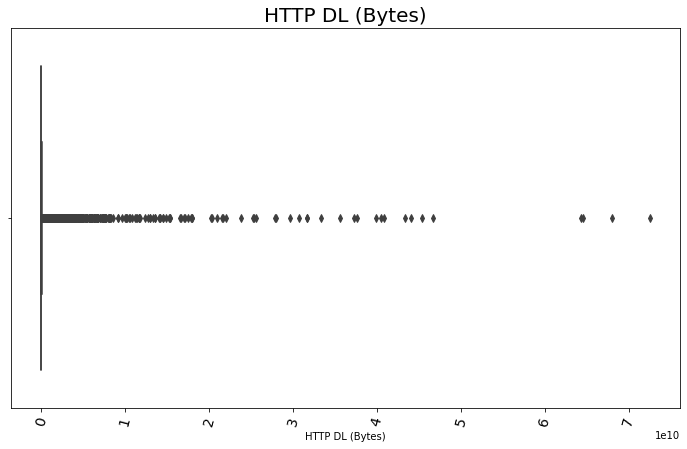

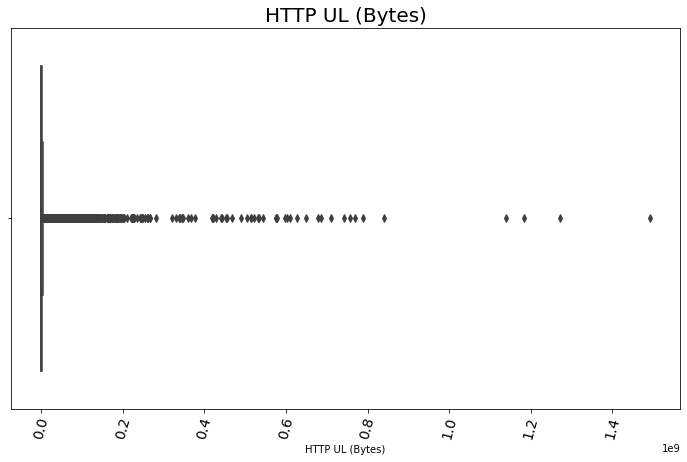

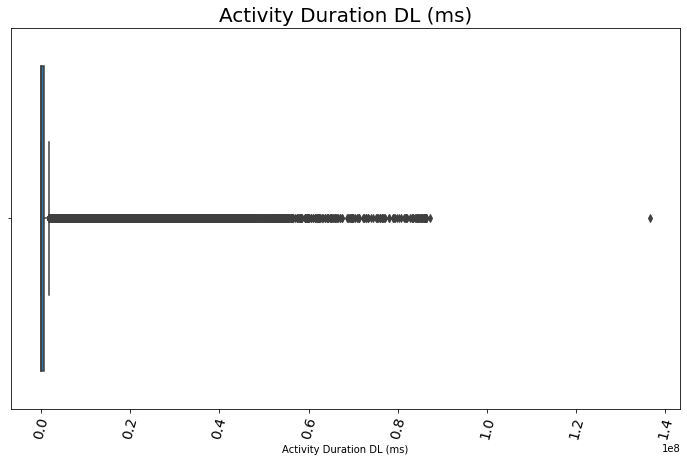

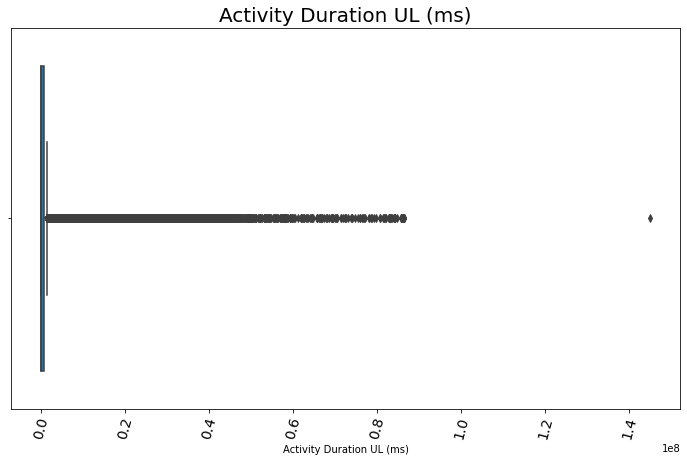

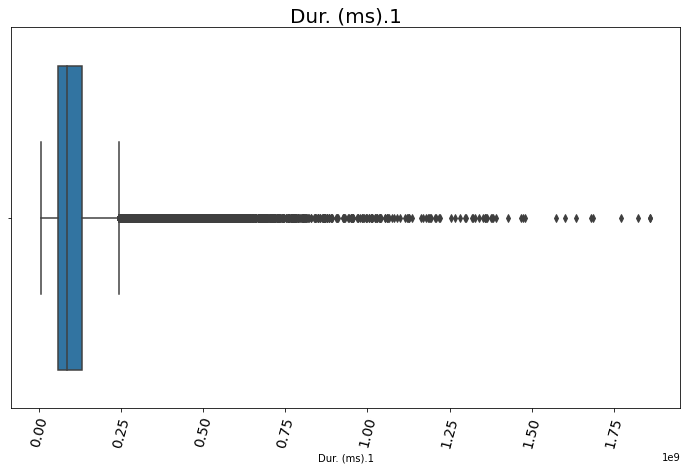

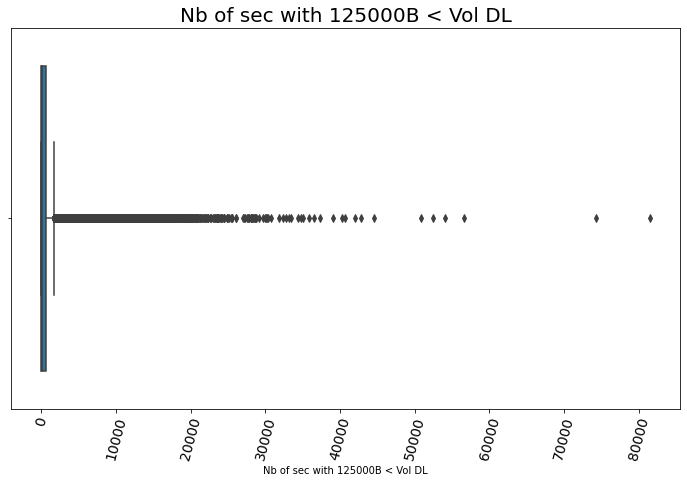

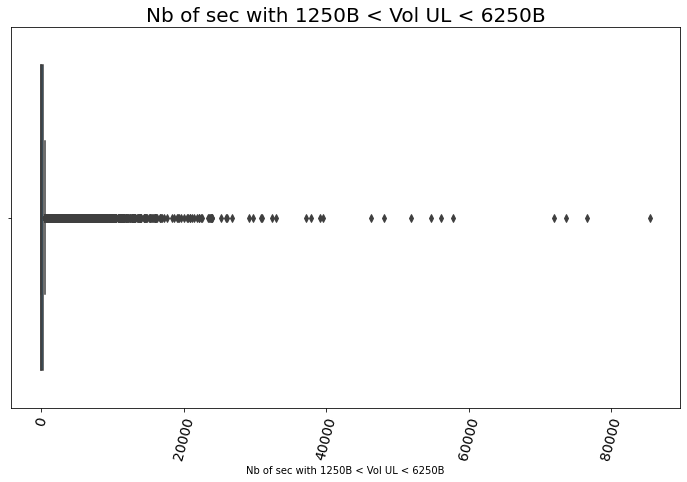

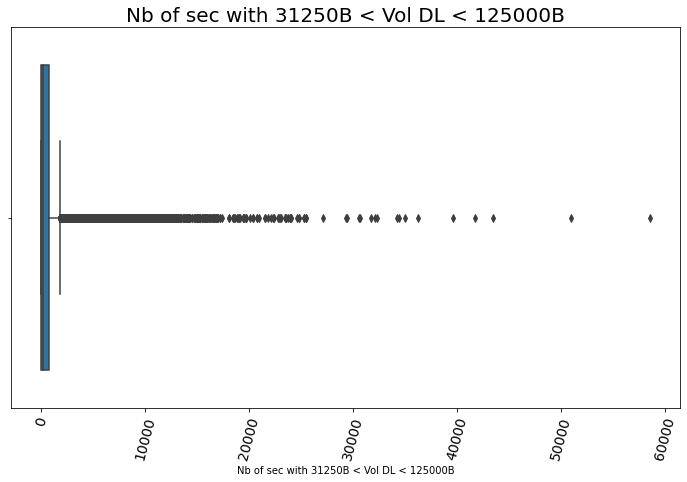

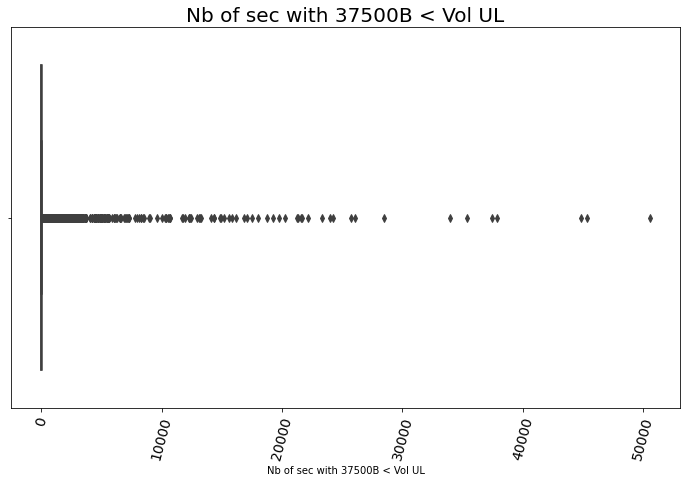

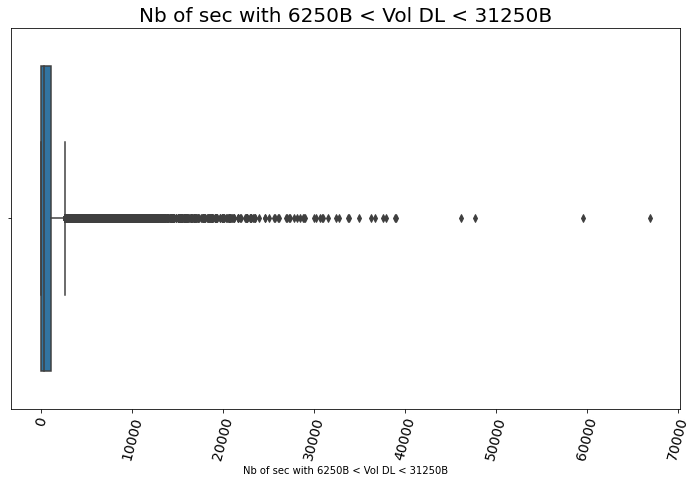

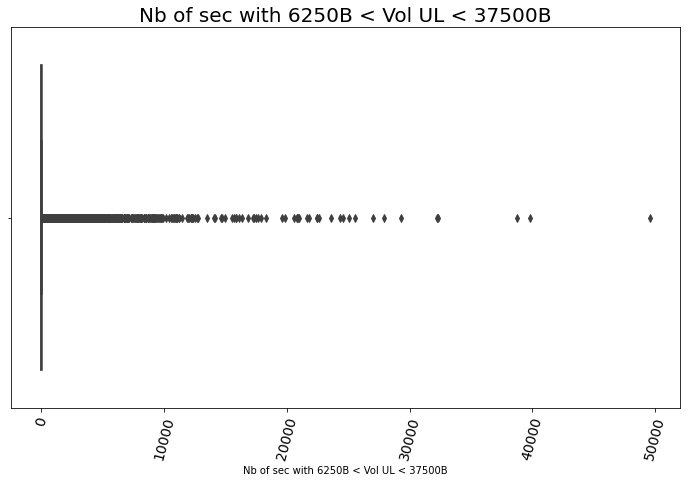

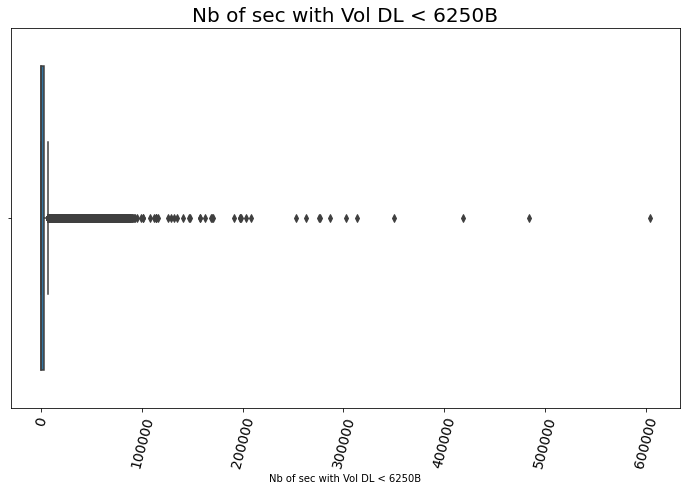

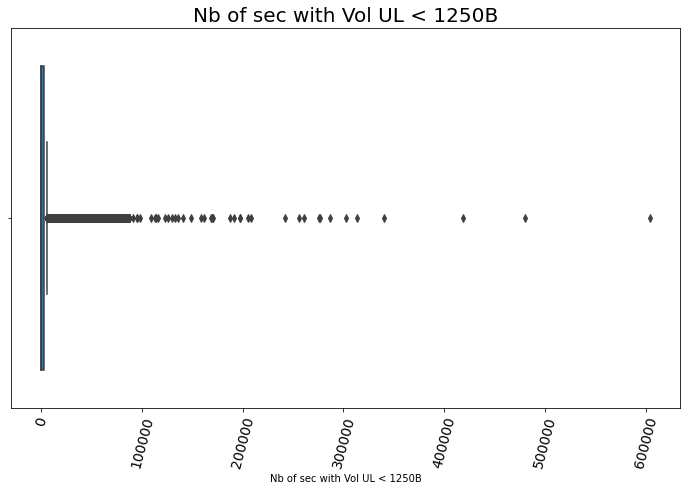

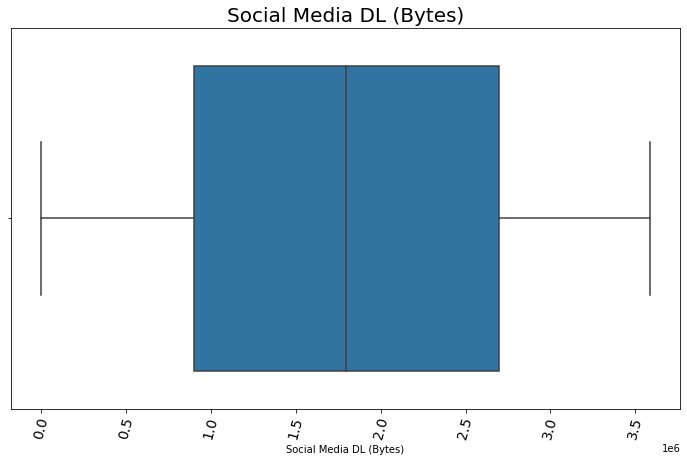

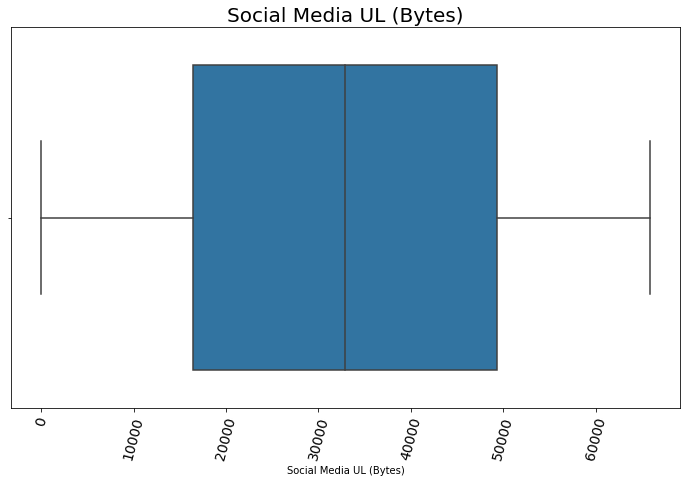

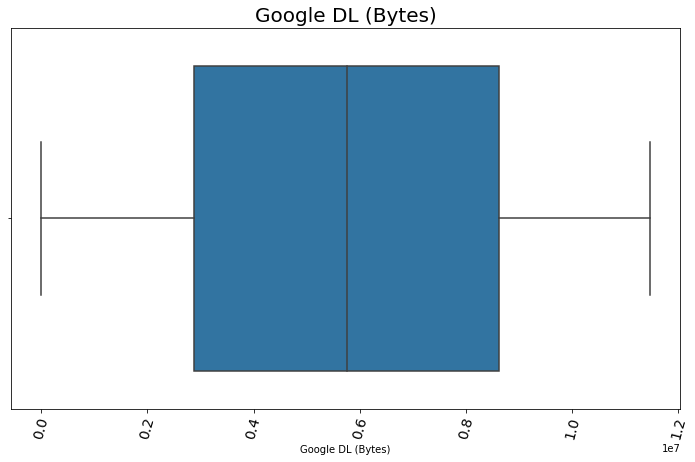

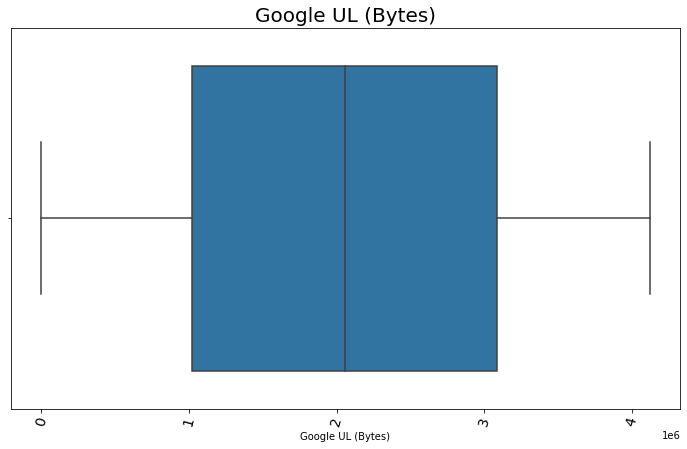

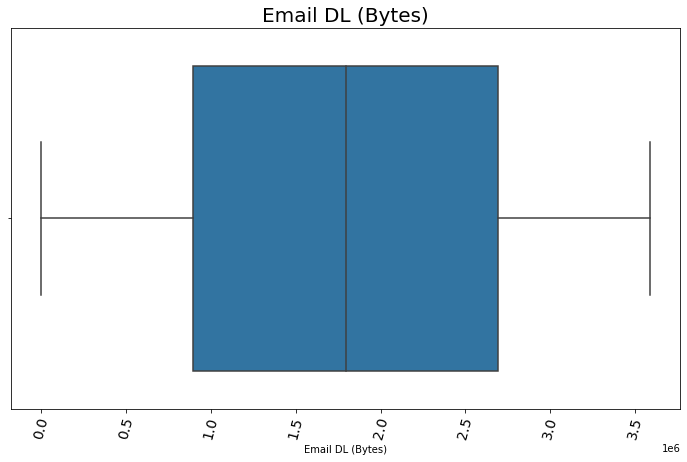

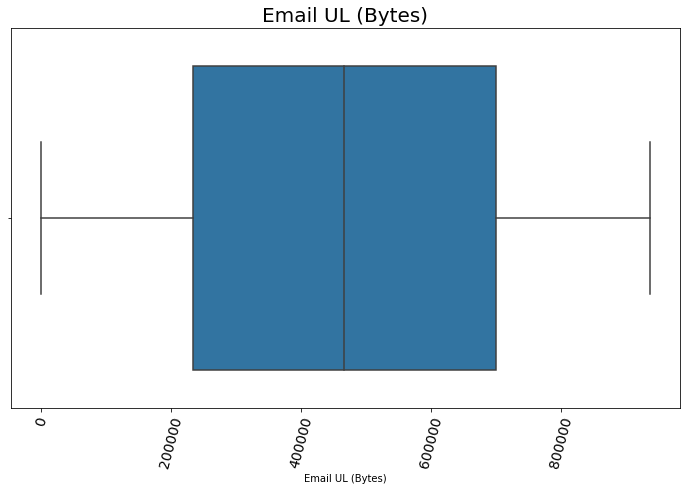

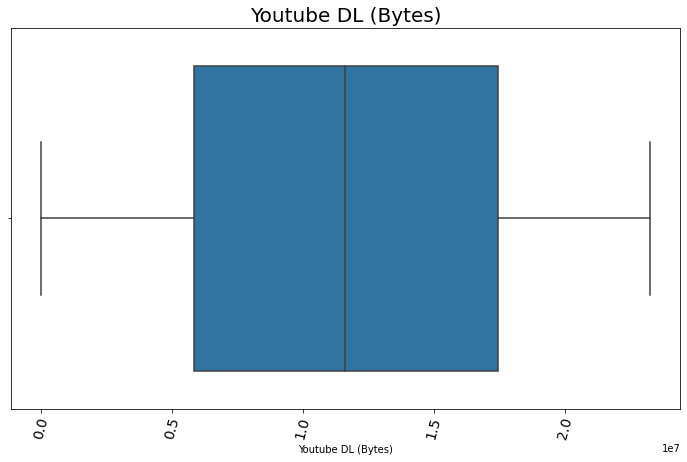

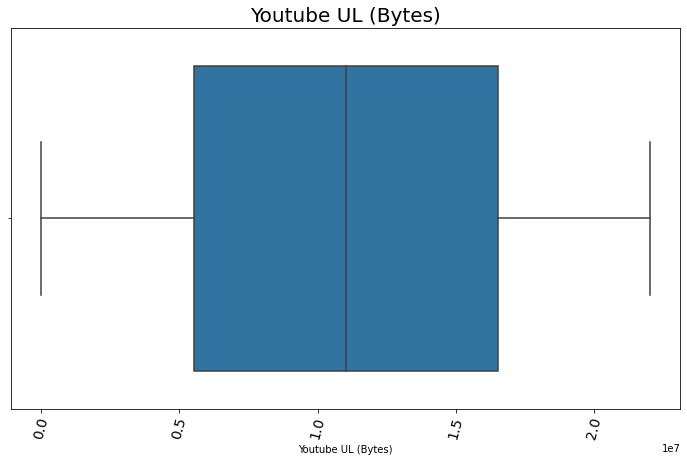

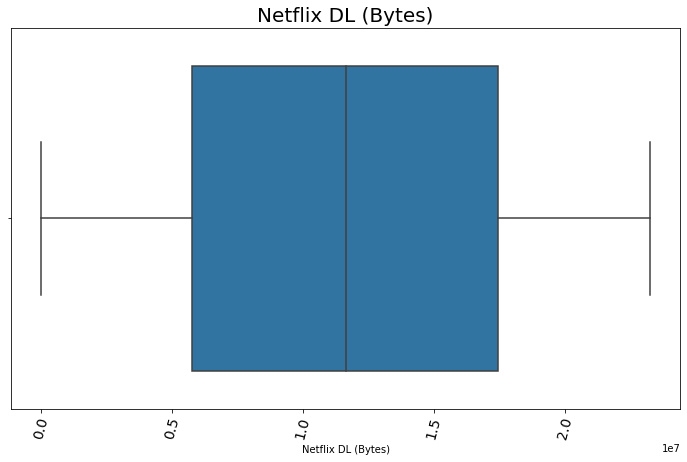

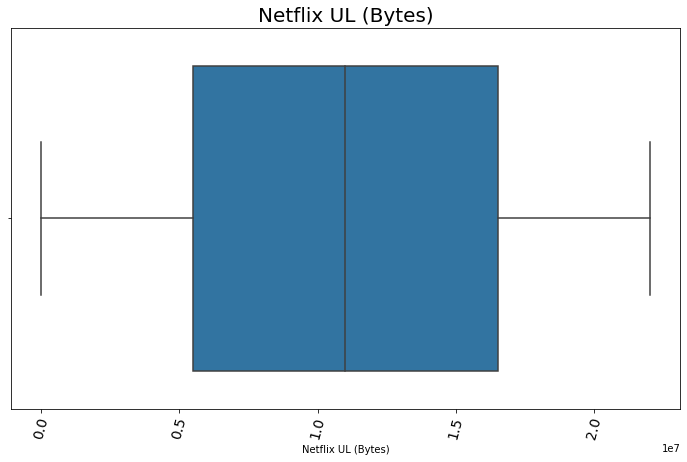

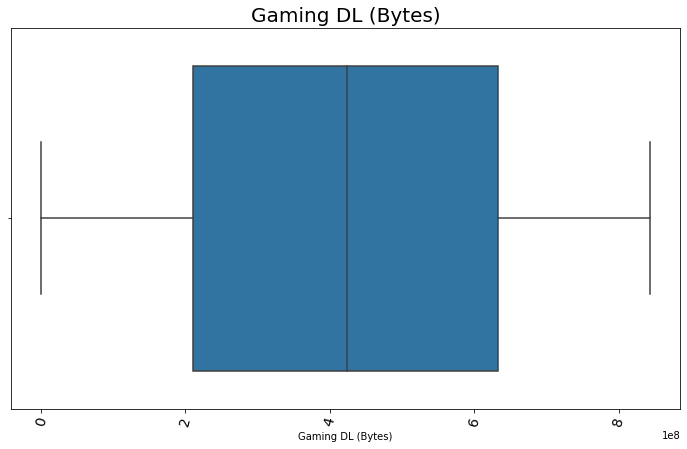

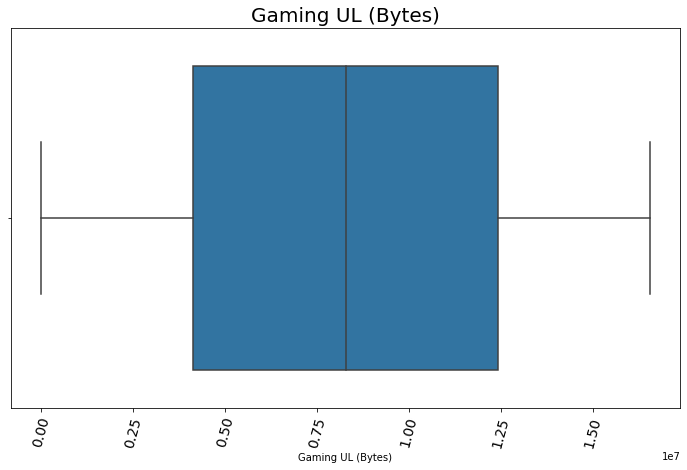

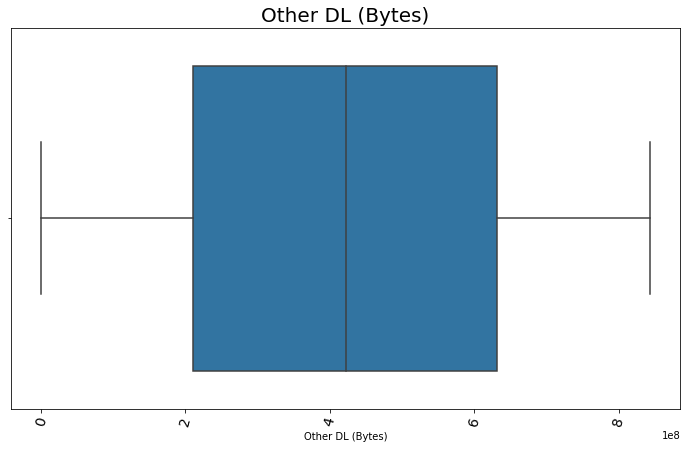

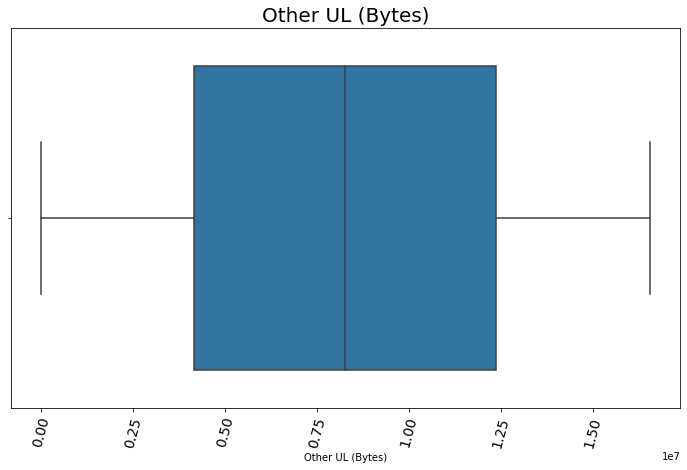

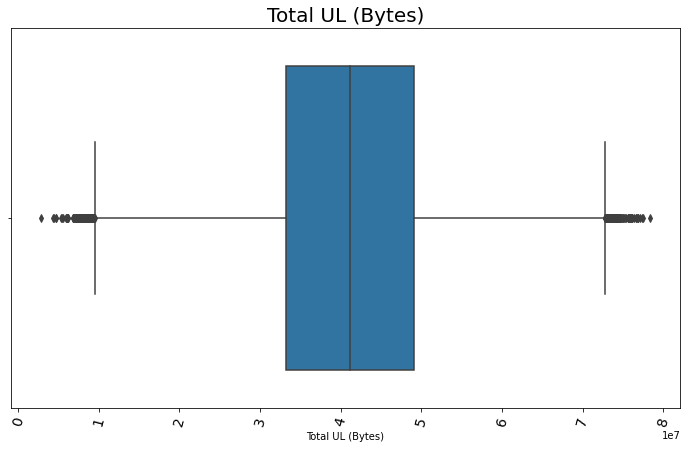

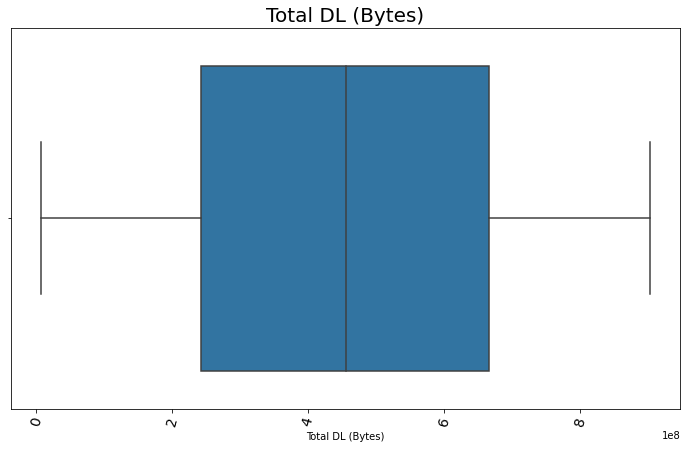

In [27]:
# def fix_outlier(df, column):
#     df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
#     return df[column]
# fixed_df = clean_df.copy()

numerical_columns = clean_df.select_dtypes(include='number').columns.tolist()
for col in numerical_columns:
    # fixed_df[col] = fix_outlier(clean_df, col)
    plot_box(df, col, col)

What we can understand from the above box charts is that there are many outliers for some of the columns such as `Avg RTT DL (ms)`, `250 Kbps < DL TP < 1 Mbps (%)`, and `UL TP > 300 Kbps (%)` but all the social media and app columns don't have outliers. 

#### Histogram plots
This can also be confirmed using histograms. What we will see is that most of the data will be clustered on one side and there will be a few straggler with small frequency on the other side. 

In [21]:
# numerical_columns = clean_df.select_dtypes(include='number').columns.tolist()
# for col in numerical_columns:
#     plot_hist(df, col, 'gold')

### Bivariate Analysis
Here, I am exploreing the relationship between each application & the total DL+UL data using appropriate methods

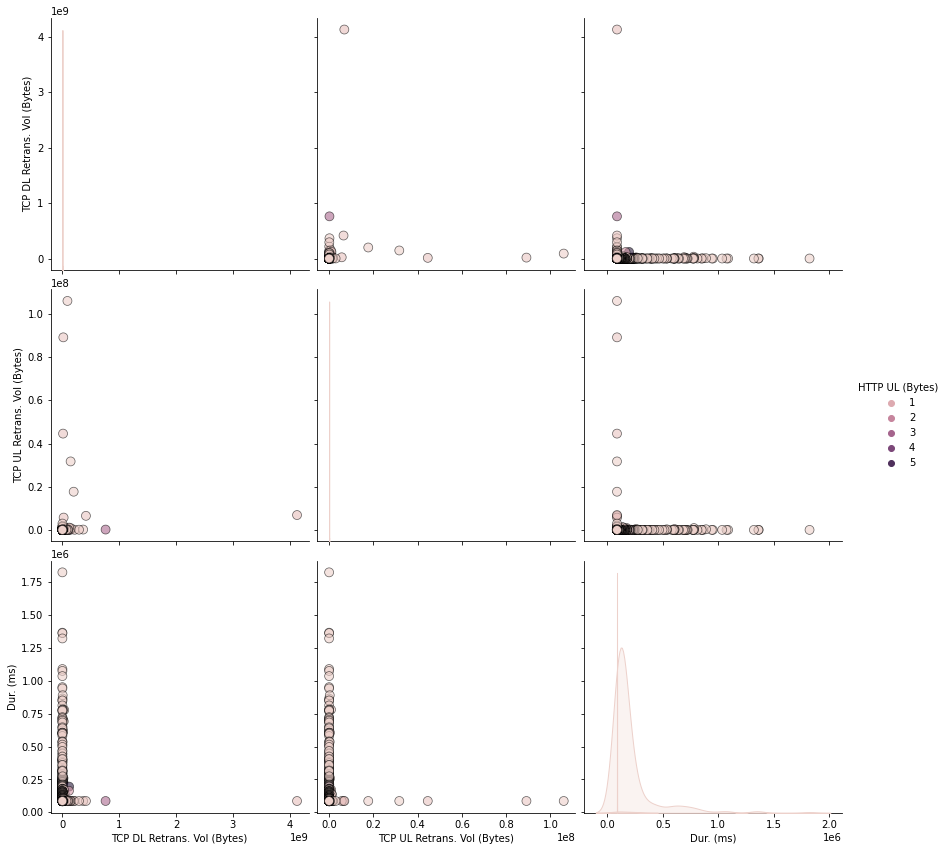

In [21]:
dfPair = clean_df.loc[:1000, ["HTTP UL (Bytes)", "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)", "Dur. (ms)"]]
sns.pairplot(dfPair, hue = "HTTP UL (Bytes)", diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=4)

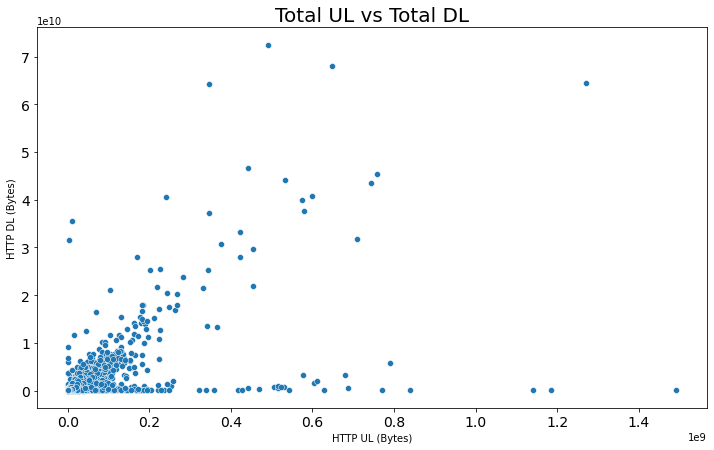

In [91]:
# df.boxplot(figsize=(12, 9))
plot_scatter(clean_df, "HTTP UL (Bytes)", "HTTP DL (Bytes)", "Total UL vs Total DL", None, None)

### Variable transformations
- segment the users into top five decile classes based on the total duration
- compute the total data (DL+UL) per decile class.

In [20]:
app_columns = [col for col in df.columns if col.endswith('L (Bytes)')][2:-2]
app_columns.append('Dur. (ms)')
# display(app_columns)
user_app_ULDL_data_vol = df.groupby(by=['IMSI'])[app_columns].sum()
user_app_ULDL_data_vol.head()
user_app_total_data_vol.head()

user_app_total_data_vol = user_app_ULDL_data_vol.copy()
# group columns into tuples
# app_ULDLs = [
app_ULDL_columns = user_app_total_data_vol.columns.tolist()
app_columns = [[app_ULDL_columns[i], app_ULDL_columns[i+1]] for i in range(0, len(app_ULDL_columns)-1, 2)]
app_columns

for app in app_columns:
    app_name = " ".join(app[0].split()[:-2]).strip()
    user_app_total_data_vol[app_name] = user_app_total_data_vol[app].sum(axis=1)
    user_app_total_data_vol.drop(columns=app, inplace=True)
user_app_total_data_vol.head()

,Dur. (ms),Social Media,Google,Email,Youtube,Netflix,Gaming,Other
IMSI,,,,,,,,
204047108489451.0,869844.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08
204080810288647.0,877385.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08
208200101016140.0,86019.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08
208200101127285.0,86254.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08
208200101148045.0,573923.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09


In [21]:
user_app_total_data_vol['decile_rank'] = pd.qcut(user_app_total_data_vol['Dur. (ms)'], 10, labels=False)

top_5_decile = user_app_total_data_vol[user_app_total_data_vol['decile_rank'] > 4 ]

top_5_decile.head()

,Dur. (ms),Social Media,Google,Email,Youtube,Netflix,Gaming,Other,decile_rank
IMSI,,,,,,,,,
204047108489451.0,869844.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08,9
204080810288647.0,877385.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08,9
208200101148045.0,573923.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09,9
208200101148075.0,372454.0,3787423.0,19749603.0,4327786.0,50907243.0,29882137.0,835218898.0,4.797783e+08,9
208200101148136.0,232058.0,5192710.0,14064424.0,5541425.0,11823461.0,17047546.0,939598732.0,1.069429e+09,8


#### Total data per decile class

In [22]:
top_5_decile_app_volume = top_5_decile.groupby('decile_rank')[['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']].sum()
top_5_decile_app_volume.head()

,Social Media,Google,Email,Youtube,Netflix,Gaming,Other
decile_rank,,,,,,,
5,2.368667e+10,1.011446e+11,2.937519e+10,2.942542e+11,2.942213e+11,5.602022e+12,5.620203e+12
6,2.272677e+10,9.648990e+10,2.788995e+10,2.805453e+11,2.774973e+11,5.369615e+12,5.282693e+12
7,2.919594e+10,1.237756e+11,3.588072e+10,3.590882e+11,3.591808e+11,6.805374e+12,6.795237e+12
8,3.437660e+10,1.467480e+11,4.243359e+10,4.256171e+11,4.265205e+11,8.098630e+12,8.085644e+12
9,5.612191e+10,2.404064e+11,6.977190e+10,6.982836e+11,6.957506e+11,1.318250e+13,1.319225e+13


<AxesSubplot:title={'center':'Total data usage volume vs Decile rank'}, xlabel='decile_rank'>

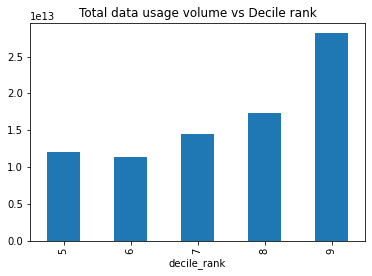

In [23]:
top_5_decile_total_volume = top_5_decile_app_volume.sum(axis=1)
top_5_decile_total_volume.plot.bar(title='Total data usage volume vs Decile rank')

#### Correlation Analysis

Columns to consider:
- Social Media
- Google 
- Email
- Youtube
- Netflix
- Gaming
- Other

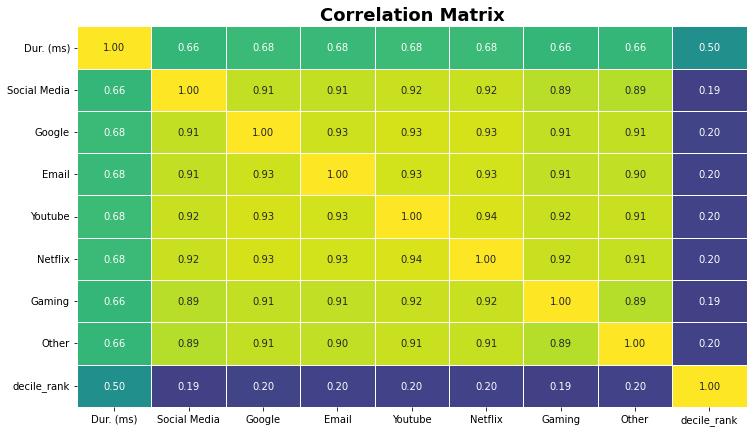

In [25]:
# user_app_total_data_vol.head()
plot_heatmap(user_app_total_data_vol.corr(), "Correlation Matrix")

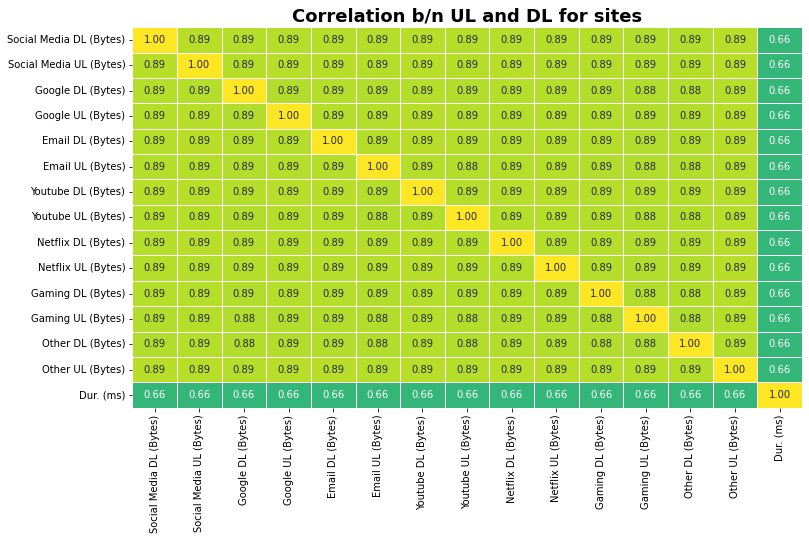

In [26]:
plot_heatmap(user_app_ULDL_data_vol.corr(), "Correlation b/n UL and DL for sites")

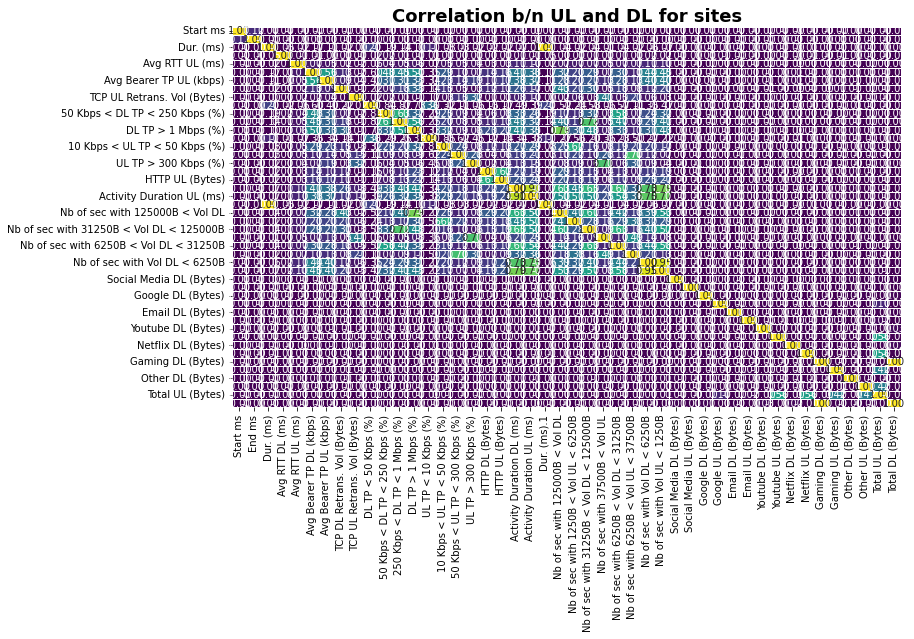

In [27]:
plot_heatmap(clean_df.corr(), "Correlation b/n UL and DL for sites")

### Dimensionality Reduction 

perform a principal component analysis to reduce the dimensions of your data and provide a useful interpretation of the results (Provide your interpretation in four (4) bullet points-maximum). 


In [50]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  object        
 1   Start                                     150001 non-null  datetime64[ns]
 2   End                                       150001 non-null  datetime64[ns]
 3   IMSI                                      150001 non-null  object        
 4   MSISDN/Number                             150001 non-null  object        
 5   IMEI                                      150001 non-null  object        
 6   Last Location Name                        150001 non-null  object        
 7   Handset Manufacturer                      150001 non-null  object        
 8   Handset Type                              150001 non-null  object        
 9   Start ms       

In [27]:
df[['Dur. (ms).1', 'Dur. (ms)']]

,Dur. (ms).1,Dur. (ms)
0,1.823653e+09,1823652.0
1,1.365104e+09,1365104.0
2,1.361763e+09,1361762.0
3,1.321510e+09,1321509.0
4,1.089009e+09,1089009.0
...,...,...
149996,8.123076e+07,81230.0
149997,9.797070e+07,97970.0
149998,9.824953e+07,98249.0
149999,9.791063e+07,97910.0
